In [60]:
%load_ext autoreload
%autoreload 2

# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import contextily as cx

import datetime


from matplotlib.pyplot import cm
from shapely.geometry import Point

from Code.prep         import create_folders

from Code.load_data    import get_his_dis,\
                              get_drainage,\
                              extract_file
from Code.prepare_data import prep_index_data,\
                              prep_mod_rain_data,\
                              prep_rain_data,\
                              prep_his_dis_dic,\
                              prep_mod_dis_data,\
                              merge_rain_data,prep_his_dis_data

from Code.clean_data   import clean_data
from Code.plot_data    import logscaled_plot,detrend_plot,data_enso_plot,climatology_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
files_folder   = 'Data/Files'
figures_folder = 'Data/Figures'

create_folders( files_folder )
create_folders( figures_folder )

In [ ]:
# Plot map with station locations    
# Make sure the coordinates are in order 
df_coords_dis = pd.read_csv(f'{files_folder}/CoordinatesDis.csv')
df_coords_dis['coords'] = list( zip(df_coords_dis.Lon, df_coords_dis.Lat) )


df_coords_rain = pd.read_csv(f'{files_folder}/CoordinatesRiver.csv')
df_coords_rain['coords']= list( zip(df_coords_rain.Lon, df_coords_rain.Lat) )

geo_df_dis = gpd.GeoDataFrame( df_coords_dis, crs  ={'init': 'epsg:4326'},
                          geometry = df_coords_dis['coords'].apply(Point) ).to_crs(epsg=4326)

geo_df_rain= gpd.GeoDataFrame( df_coords_rain, crs ={'init': 'epsg:4326'},
                              geometry = df_coords_rain['coords'].apply(Point) ).to_crs(epsg=4326) #3857 for the terrain map


df_shape=gpd.read_file(f'{files_folder}/PHL_climatetype.shp')
fig, ax = plt.subplots(figsize = (25,25) )
df_shape.plot( ax=ax, alpha = 0.6, cmap='gist_earth',edgecolor = 'black', )
geo_df_dis.plot( ax=ax, alpha = 0.4, color = 'blue', markersize = 400,edgecolor = 'black', label = 'Discharge Stations'  )
geo_df_rain.plot( ax=ax, alpha = 0.4,color = 'red', markersize = 400,edgecolor = 'black', label = 'Rainfall Stations'  )
plt.title('HESS Paper Climate Categories',fontsize=15)
plt.xlabel('Latitude',fontsize=30)
plt.ylabel('Longitude',fontsize=30)
plt.legend( fontsize=15,frameon=False,title='LEGEND' )
#plt.savefig( f'{figures_folder}/paired_rain_dis_map.eps',dpi=600 )
plt.show()

In [ ]:
''' Historic Discharge data '''
dict_data = {}
l_files = extract_file( 'Historical/' )
for name in l_files:
    label = name.split('/')[-1] \
                .split('.')[0] \
                .replace(' ', '_') \
                .replace('(', '') \
                .replace(')', '')
    fol    = name.split('/')[-2].lower()
    print(label)
    df_excel = pd.read_excel(name)
    df_index = get_his_dis(df_excel) 
    dict_data[f"{fol}_{label}"] = {
        'data'     : prep_his_dis_dic(df_index,df_excel),
        'drainage': get_drainage(df_excel)
    }

In [64]:
''' Prepare datasets '''

# Indeces
parernt_dir     = 'Indices/CookedFolder'
df_nino34a_rel  = prep_index_data( parernt_dir, 'nino3.4a_rel', 'NINO 3.4 REL' )

# Rainfall Data (modern)
df_rain_mod, rain_mod_label = prep_mod_rain_data( 'Modern/' )

# Rainfall Data (historic + mid century)
df_rain_hist, df_rain_hist_label = prep_rain_data (
    filename  = f'{files_folder}/1901_1940Rainfall.csv',
    labelname = 'hist' 
)
df_rain_mid, df_rain_mid_label   = prep_rain_data( 
    filename  = f'{files_folder}/Rainfall1951_1990.csv',
    labelname = 'mid'
)

# Dischrage Data (modern)
df_hess, hess_labels  = prep_mod_dis_data( 'HESS/' )

# Discharge Data (historic)
hist_dis = prep_his_dis_data( dict_data )

Prep Index data
Prep Modern data
Prep Historical/Mid data
Prep Historical/Mid data
Prep Modern Discharge Data
Prep Historic Discharge Data


In [65]:
''' Prepare clean data variable names '''

# Clean Rainfall names
rain_list_mod = [ key.split('mod_')[-1].lower() for key in df_rain_mod.columns ]
rain_list_mod.remove('date')

rain_list_mid = [ key.split('mid_')[-1].lower() for key in df_rain_mid.columns ]
del rain_list_mid[0:4]

rain_list_hist= [ key.split('hist_')[-1].lower() for key in df_rain_hist.columns ]
del rain_list_hist[0:4]

# Clean River Discharge names
river_list_hist = [ key.split('_')[1].lower() for key in hist_dis  ]
river_list_hess = [ key.split('hess_')[-1].lower() for key in df_hess.columns ] 

In [66]:
''' Merge datasets ''' 

# Merge historical and modern rainfall data
df_rain_mod_hist = df_rain_mod.copy()

rain_drop_list   = [
                    'mod_ambulong', 'mod_aparri', 'mod_baguio', 'mod_borongan', 'mod_butuan', 'mod_cabanatuan', 'mod_calapan', 'mod_casiguran', 
                    'mod_catbalogan', 'mod_clark', 'mod_davao', 'mod_dipolog', 'mod_dumaguete','mod_gen', 'mod_hinatuan', 'mod_iloilo', 'mod_laoag', 
                    'mod_lumbia', 'mod_maasin', 'mod_mactan', 'mod_manila', 'mod_surigao', 'mod_tagbilaran', 'mod_tuguegarao', 'mod_vigan',
                    'hist_ambulong', 'hist_aparri', 'hist_baguio', 'hist_borongan', 'hist_butuan', 'hist_cabanatuan', 'hist_calapan', 
                    'hist_casiguran', 'hist_catbalogan', 'hist_clark', 'hist_davao', 'hist_dipolog', 'hist_dumaguete', 'hist_gen', 
                    'hist_hinatuan', 'hist_iloilo', 'hist_laoag', 'hist_lumbia', 'hist_maasin', 'hist_mactan', 
                    'hist_manila', 'hist_surigao', 'hist_tagbilaran', 'hist_tuguegarao', 'hist_vigan', 

                   ]

df_rain_mod_hist_dropped = merge_rain_data (  
    df_a      = df_rain_hist, 
    df_b      = df_rain_mod_hist,
    list_a    = rain_list_hist, 
    list_b    = rain_list_mod, 
    drop_list = rain_drop_list, 
    mlabel    = 'mod' 
)

df_rain_mod_hist_dropped.rename( columns={
        'Date':'Date','ambulong': 'mod_hist_ambulong', 'aparri': 'mod_hist_aparri', 'baguio': 'mod_hist_baguio', 'borongan': 'mod_hist_borongan','butuan':'mod_hist_butuan' ,'cabanatuan':'mod_hist_cabanatuan',
        'clark': 'mod_hist_clark', 'dipolog': 'mod_hist_dipolog','davao':'mod_hist_davao','dumaguete':'mod_hist_dumaguete', 'gen': 'mod_hist_gen', 'hinatuan': 'mod_hist_hinatuan','hist_malaybalay':'mod_hist_malaybalay',
        'hist_munoz':'mod_hist_munoz', 'iloilo':'mod_hist_iloilo', 'laoag':'mod_hist_laoag', 'lumbia':'mod_hist_lumbia', 'maasin':'mod_hist_maasin', 'mactan':'mod_hist_mactan',
        'manila':'mod_hist_manila', 'mod_cotabato':'mod_hist_cotobato', 'mod_daet':'mod_hist_daet', 'mod_daniel':'mod_hist_daniel', 'surigao':'mod_hist_surigao',
        'tagbilaran':'mod_hist_tagbilaran', 'tuguegarao':'mod_hist_tuguegarao', 'vigan':'mod_hist_vigan','calapan':'mod_hist_calapan', 'casiguran':'mod_hist_casiguran','catbalogan':'mod_hist_catbalogan'
                                            }, inplace=True )
    
    
# Merge modern + historical with mid century rainfall dataset
df_rain_mod_hist_mid = df_rain_mod_hist_dropped.copy()
rain_list_mod_hist = [ key.split('_')[-1].lower() for key in df_rain_mod_hist_dropped.columns ]
rain_list_mod_hist.remove('date')

rain_drop_list = [
                'mid_ambulong', 'mid_aparri', 'mid_baguio', 'mid_borongan','mid_butuan','mid_cabanatuan', 'mid_calapan', 'mid_casiguran', 'mid_catbalogan', 'mid_clark','mid_cotobato','mod_hist_cotobato',
                'mid_daet', 'mid_daniel', 'mid_dipolog', 'mid_dumaguete', 'mid_gen', 'mid_hinatuan', 'mid_laoag', 'mid_maasin', 'mid_malaybalay', 'mid_manila', 'mid_surigao', 'mid_tagbilaran', 'mid_tuguegarao', 
                'mid_vigan', 'mod_hist_ambulong', 'mod_hist_aparri', 'mod_hist_baguio', 'mod_hist_borongan','mod_hist_butuan', 'mod_hist_cabanatuan', 'mod_hist_calapan', 'mod_hist_casiguran', 'mod_hist_catbalogan', 'mod_hist_clark',
                'mod_hist_daet', 'mod_hist_daniel', 'mod_hist_dipolog','mod_hist_dumaguete','mod_hist_hinatuan','mod_hist_laoag','mod_hist_maasin', 'mod_hist_malaybalay','mod_hist_manila','mod_hist_gen',
                'mod_hist_surigao', 'mod_hist_tagbilaran', 'mod_hist_tuguegarao', 'mod_hist_vigan',
                 ]

df_rain_dropped = merge_rain_data ( 
    df_a      = df_rain_mid, 
    df_b      = df_rain_mod_hist_mid, 
    list_a    = rain_list_mid, 
    list_b    = rain_list_mod_hist, 
    drop_list = rain_drop_list, 
    mlabel    = 'mod_hist' 
)

In [ ]:
#FIGURE WITH RAW RAINFALL DATA
#def rain_raw(df):

color = cm.terrain( np.linspace(0, 1, 30), alpha=0.9 )
plt.figure( figsize=(24,16) )
for i,c in zip(range(1,30),color):
    plt.plot(df_rain_dropped['Date'],df_rain_dropped.iloc[:,i], c=c,label = df_rain_dropped.columns[i])
#plt.setp(axes, yticks=[])
plt.tight_layout()
plt.legend(loc='best')
plt.ylim(0,3500)
plt.xlim([datetime.date(1900, 1, 1), datetime.date(2020, 12, 31)])
plt.ylabel('Rainfall (mm/month)', color='k')
#plt.savefig(f'{figures_folder}/Raw Rainfall Data.eps', dpi = 600, rasterized=True)
plt.show()

In [67]:
# RIVER DISCHARGE DATA
# MAKE ONE BIG DATA SET WITH HESS, HESS + HIST, HIST River Discharge data in monthly means (mm)

df_hess_copy   = df_hess.copy()
df_hess_hist   = []
hess_drop_list = ['historical_Maragayap', 'hess_maragayap','historical_Mambusao_River', 'hess_mambusao',
                                         'historical_Ganano_River', 'hess_ganano','historical_Jalaur', 'hess_jalaur',
                                         'historical_Gabayan', 'hess_gabayan','historical_Agusan_River','hess_agusan',
                                         'historical_Magat_River','hess_magat','historical_Laoag_River','hess_laoag']

for river_name_clean, river_name in zip( river_list_hist, hist_dis.keys() ) :
    
    #print(river_name_clean, river_name)
    if river_name_clean in river_list_hess:
        if f'{river_name_clean}' in f'{hess_labels}':
            hess_labels_clean = 'hess_'+river_name_clean
            #print(hess_labels_clean)
        df_hess_copy=df_hess_copy.merge( hist_dis[river_name], how = 'outer', on = 'Year',  validate = '1:1' )
        #display(df_hess_copy.head())
        df_hess_copy[river_name_clean] = df_hess_copy[f'{hess_labels_clean}'].combine_first(
                                                      df_hess_copy[f'{river_name}'])
        df_hess_copy=df_hess_copy.sort_values('Year').reset_index(drop=True)
        
    else:

        df_hess_copy = df_hess_copy.merge(hist_dis[river_name], how = 'outer', on = 'Year', validate = '1:1' )
        df_hess_copy=df_hess_copy.sort_values('Year').reset_index(drop=True)
        #display(df_hess_copy.head())
    
    
df_hess_hist = df_hess_copy

df_hess_hist_dropped = df_hess_hist.drop(hess_drop_list, axis=1)


In [ ]:
# FIGURE WTIH RAW DISCHARGE DARA

color = cm.terrain( np.linspace(0,1,60), alpha = 0.9 )
plt.figure( figsize=(24,16) )
for i,c in zip( range(1,60),color ):
    plt.plot( df_hess_hist_dropped['Year'],df_hess_hist_dropped.iloc[:,i], c=c, label = df_hess_hist_dropped.columns[i] )
plt.legend(loc='best')
plt.ylim(0,5000)
plt.xlim([datetime.date(1900, 1, 1), datetime.date(2020, 12, 31)])
plt.ylabel('Discharge (mm/month)', color='k')
#plt.savefig(f'{figures_folder}/Raw LOG Discharge Data.eps', dpi = 600, rasterized=True)
plt.show()

In [ ]:
''' Clean Data Set '''

# HESS colors: CTI - black ; CTII - green ; CTIII - orange; CTIV - brown; CPE I - indigo; CPE II - orange ; CPE III - piink ; 

criteria_dis = pd.read_csv(f'{files_folder}/CriteriaTableDis_HESS.csv')
df_clean_clim_dis_I   = clean_data(df_hess_hist_dropped,criteria_dis,'River Name','Climate Type',1,'Year',df_nino34a_rel)
df_clean_clim_dis_II  = clean_data(df_hess_hist_dropped,criteria_dis,'River Name','Climate Type',2,'Year',df_nino34a_rel)
df_clean_clim_dis_III = clean_data(df_hess_hist_dropped,criteria_dis,'River Name','Climate Type',3,'Year',df_nino34a_rel)
df_clean_clim_dis_IV  = clean_data(df_hess_hist_dropped,criteria_dis,'River Name','Climate Type',4,'Year',df_nino34a_rel)


criteria_rain= pd.read_csv(f'{files_folder}/CriteriaTableRain_HESS.csv')
df_clean_clim_rain_I  = clean_data( df_rain_dropped,criteria_rain,'Station Name','Climate Type',1,'Date',df_nino34a_rel ) 
df_clean_clim_rain_II = clean_data( df_rain_dropped,criteria_rain,'Station Name','Climate Type',2,'Date',df_nino34a_rel ) 
df_clean_clim_rain_III= clean_data( df_rain_dropped,criteria_rain,'Station Name','Climate Type',3,'Date',df_nino34a_rel) 
df_clean_clim_rain_IV = clean_data( df_rain_dropped,criteria_rain,'Station Name','Climate Type',4,'Date',df_nino34a_rel) 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


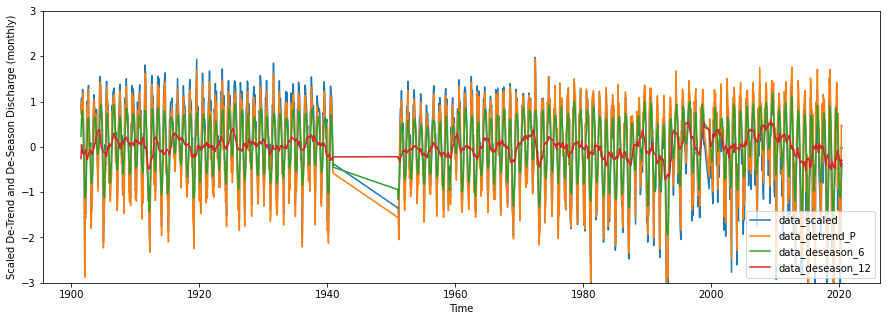

In [71]:
''' Plotting for Detrend, Summary, Box-Plot'''
# HESS colors: CTI - black ; CTII - green ; CTIII - orange; CTIV - brown; CPE I - indigo; CPE II - orange ; CPE III - piink ;

detrend_plot( df         = df_clean_clim_rain_I, 
              savefolder = figures_folder, 
              savelabel  = 'Climate_Type_1_Station_Name')



Text(0.5, 0.98, 'Climate Type IIII, r value')

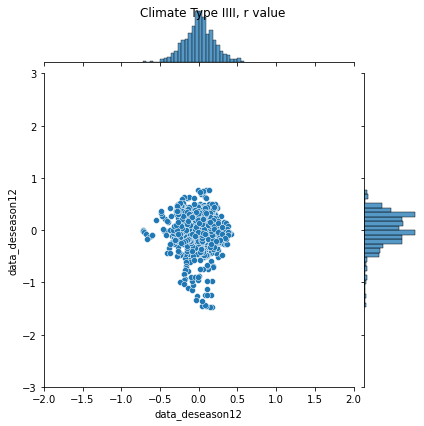

In [72]:
# Correlation plots with r value of river and rainfall data for the same climate type 
p =sns.jointplot(x=df_clean_clim_rain_I['data_deseason12'],y=df_clean_clim_dis_I['data_deseason12'],xlim=[-2,2], ylim=[-3,3])
p.fig.suptitle(f'Climate Type IIII, r value') 
#plt.savefig(f'../discharge/Data/Images/Dec17/climIIII.eps', dpi=400)
